<a href="https://colab.research.google.com/github/ptleskin/numberOfDominoTilings/blob/main/numberOfDominoTilings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Colab Notebook was inspired by Mathologer's video [*The ARCTIC CIRCLE THEOREM or Why do physicists play dominoes?*](https://www.youtube.com/watch?v=Yy7Q8IWNfHM&t=1856s).

The codes provided contain functions for calculating the number of tilings and downloading an animated example of possible ways to tile a grid of a specified shape. 

petri.leskinen@icloud.com, December 27, 2020.

# install the dependencies

In [ ]:
import numpy as np
import scipy.linalg as linalg

import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

from itertools import permutations, product
from collections import defaultdict
!apt install imagemagick

!mkdir images

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono g

## Define the needed functions

In [ ]:
def calculateMatrix(M):
  '''
  Calculates:
  A: the complex 'adjacency' matrix, where |det(A)| = number of possible tilings
  B: matrix of possible domino locations
  N: a lookup table of which cell indices (-n, -n+1, ..., -1, 1, 2, ..., n-1, n)
    corresponds to which cell coordinate
  '''
  M = np.array(M)
  N = np.zeros(M.shape, dtype=int)
  ym, xm = N.shape

  # index the 'black' (positive int) and 'white' (negative int) cell
  i, j = 0, 0
  for y in range(ym):
    for x in range(xm):
      if M[y][x]:
        if (x+y)%2:
          i += 1
          N[y][x] = i
        else:
          j -= 1
          N[y][x] = j
  s = int(np.max(N))
  A = np.zeros((s, s), dtype=complex)
  B = np.zeros((s, s), dtype=object)

  ym, xm = N.shape
  # A: 'adjacency' matrix with 1 for horizontal pair, and i for vertical pair:
  for y in range(ym):
    for x in range(xm):
      xn = N[y][x]
      if xn != 0:
        if x+1<xm:
          # horizontal pair, 1
          yn = N[y][x+1]
          if yn<0:
            # print(yn, xn)
            A[xn-1][-yn-1] = 1
            B[xn-1][-yn-1] = (xn, yn)
          elif yn>0:
            # print(xn, yn)
            A[yn-1][-xn-1] = 1
            B[yn-1][-xn-1] = (xn, yn)
        if y+1<ym:
          # vertical pair, i
          yn = N[y+1][x]
          if yn<0:
            A[xn-1][-yn-1] = complex(0,1)
            B[xn-1][-yn-1] = (xn, yn)
          elif yn>0:
            A[yn-1][-xn-1] = complex(0,1)
            B[yn-1][-xn-1] = (xn, yn)
  return A, B, N


def tuple2rectangle(tpl, N):
  '''
  Convert a cell pair e.g. (2, -6)
    into a polyline path on corresponding rectangle
  Returns: (polyline, vertical) where
    vertical = True, if the tile is in a vertical position, False if horizontal
  '''
  [y],[x] = np.where(N==tpl[0])
  [y2],[x2] = np.where(N==tpl[1])
  x, x2 = sorted([x, x2])
  y, y2 = sorted([y, y2])
  return [(x, y), (x2+1, y), (x2+1, y2+1), (x, y2+1), (x, y)], x!=x2


def drawTiling(rects, ax, vcolor='orange', hcolor='blue'):
  codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY,
  ]
  for tpl in rects:
    verts, vertical = tuple2rectangle(tpl, N)
    
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor=vcolor if vertical else hcolor, lw=1)
    ax.add_patch(patch)
    ax.set_xlim(0, M.shape[0])
    ax.set_ylim(0, M.shape[1])
    ax.axis('equal')


def numberOfTilings(M):
    A, _, _ = calculateMatrix(M)
    return int(0.5+abs(linalg.det(A)))


def cell_product(*args, res = []):
    '''
    This custom generator returns the non-zero cells from the matrix M 
    similarily as the partial sums of the determinant
    so that all values are sampled from distinct rows and columns.

    e.g. cell_product([0,1],[1,3])) = [[0, 1], [0, 3], [1, 3]]
    '''
    if len(args):
      for x in args[0]:
        if not x in res:
          yield from cell_product(*args[1:], res = res+[x])
    else:
      yield res


def getTilings(B):
    '''
    Generator for all possible tilings
    '''
    # pick the non-zero matrix values
    # nonzeros = {<row_number>: [<columns with nonzero values>]}
    nonzeros= defaultdict(list)
    for y,x in zip(*np.where(B != 0)):
      nonzeros[y].append(x)

    ''' # brute force solution
    for arr in product(*nonzeros.values()):
      # pick only the sequences where all values are distinct, e.g. corresponding to distinct columns of the matrix
      if len(arr)==len(set(arr)):
        yield [B[y][x] for y,x in enumerate(arr)]
    '''
    for arr in cell_product(*nonzeros.values()):
        yield [B[y][x] for y,x in enumerate(arr)]


In [ ]:
# these function are for representing the grids
import pandas as pd

# show matrices with chessboard coloring
def apply_chessboard(val):
    r = val.copy()
    for i, row in r.iterrows():
      for j, x in row.iteritems():
        if x==0:
          st = 'color: lightgrey'
        else:
          st = 'color: white; background-color: green' if (i+j)%2 else 'color: white; background-color: black'
        r.loc[i,j] = st
    return r

def showMatrix(M):
  df=pd.DataFrame(M)
  return df.style.apply(apply_chessboard, axis=None).set_properties(**{'width':'2em', 'height':'2em', 'text-align':'center'})#.hide_index()#.hide_columns(df.columns)


# Simple example shape as shown in the video at [11:00](https://www.youtube.com/watch?v=Yy7Q8IWNfHM&t=660s).


Matrix M is a binary matrix, with 1 for cells being a part in the shape, and 0 for cells outside the shape.

In [44]:
M = [[1, 1, 0, 0, 1, 1],
     [1, 1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1, 1],
     [0, 1, 1, 1, 0, 0],
     [0, 1, 1, 1, 0, 0],
     [0, 0, 0, 0, 0, 0]
     ]

M = np.array(M)
A,B,N = calculateMatrix(M)
display(showMatrix(M))

,0,1,2,3,4,5
0,1,1,0,0,1,1
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,0,1,1,1,0,0
4,0,1,1,1,0,0
5,0,0,0,0,0,0


In [45]:
# cells with indices
display(showMatrix(N))

,0,1,2,3,4,5
0,-1,1,0,0,-2,2
1,3,-3,4,-4,5,-5
2,-6,6,-7,7,-8,8
3,0,-9,9,-10,0,0
4,0,10,-11,11,0,0
5,0,0,0,0,0,0


In [46]:
# complex matrix A with |det(A)| = #number_of_tilings
Ac = A.copy().astype('object')
Ac[Ac==complex(0,0)] = 0
Ac[Ac==complex(1,0)] = 1
Ac[Ac==complex(0,1)] = 'i'
display(showMatrix(Ac))

,0,1,2,3,4,5,6,7,8,9,10
0,1,0,i,0,0,0,0,0,0,0,0
1,0,1,0,0,i,0,0,0,0,0,0
2,i,0,1,0,0,i,0,0,0,0,0
3,0,0,1,1,0,0,i,0,0,0,0
4,0,i,0,1,1,0,0,i,0,0,0
5,0,0,i,0,0,1,1,0,i,0,0
6,0,0,0,i,0,0,1,1,0,i,0
7,0,0,0,0,i,0,0,1,0,0,0
8,0,0,0,0,0,0,i,0,1,1,i
9,0,0,0,0,0,0,0,0,i,0,1


In [22]:
print(f'\nNumber of Tilings: {numberOfTilings(M)}')


Number of Tilings: 88


# Number of tilings for the 'sunclasses'

A more complex shape in the [video](https://www.youtube.com/watch?v=Yy7Q8IWNfHM&t=860s).


In [ ]:
M = [[1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1],
     [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
     [0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0],
     [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0]]


display(showMatrix(M))
M = np.array(M)[::-1,:]
print(f'\nNumber of Tilings: {numberOfTilings(M)}')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1,1,1,0,0,1,1,1,0,0,1,1,1,0,0,1,1,1
1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1
2,0,0,0,1,1,1,0,1,1,1,1,0,1,1,1,0,0,0
3,0,0,0,0,0,1,1,1,0,0,1,1,1,0,0,0,0,0



Number of Tilings: 666


## Space Invader shape

In [ ]:
M = [[0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0],
     [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
     [1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1],
     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
     [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
     [0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0],
     [0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
     ]

display(showMatrix(M))
M = np.array(M)[::-1,:]
print(f'\nNumber of Tilings: {numberOfTilings(M)}')

,0,1,2,3,4,5,6,7,8,9,10,11
0,0,0,0,1,1,1,1,1,1,0,0,0
1,0,1,1,1,1,1,1,1,1,1,1,0
2,1,1,1,0,0,1,1,0,0,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1,1
4,0,0,1,1,1,1,1,1,1,1,0,0
5,0,1,1,0,0,1,1,0,0,1,1,0
6,0,0,1,1,0,0,0,0,1,1,0,0



Number of Tilings: 480


# Grids of shape ($2\times n$)

In [43]:
for n in range(2,13):
  print(f'n={n}: {numberOfTilings(np.ones((2,n)))} tilings')

n=2: 2 tilings
n=3: 3 tilings
n=4: 5 tilings
n=5: 8 tilings
n=6: 13 tilings
n=7: 21 tilings
n=8: 34 tilings
n=9: 55 tilings
n=10: 89 tilings
n=11: 144 tilings
n=12: 233 tilings


# Number of tilings for an Aztec Diamond

Function definition for generating Aztec Diamonds as in the video at [26:00](https://www.youtube.com/watch?v=Yy7Q8IWNfHM&t=1560s).

This code block also demonstrates that the number of tiling for an Aztec Diamong **A(n)** equals $2^{1+2+3+...+n}$.

In [ ]:
def AztecDiamond(n):
  M = np.triu(np.ones((n,n), dtype=int))
  M = np.concatenate((M[::-1,:], M))
  return np.concatenate((M, M[:,::-1]), axis=1)

# size of Aztec Diamong, note. the process slows down with n>7
n = 5
M=AztecDiamond(n)
display(showMatrix(M))

M = np.array(M)[::-1,:]
print(f'\nNumber of Tilings: {numberOfTilings(M)}\n2^(1+2+..+n): {2**(n*(n+1)//2)}')


,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,1,1,0,0,0,0
1,0,0,0,1,1,1,1,0,0,0
2,0,0,1,1,1,1,1,1,0,0
3,0,1,1,1,1,1,1,1,1,0
4,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1
6,0,1,1,1,1,1,1,1,1,0
7,0,0,1,1,1,1,1,1,0,0
8,0,0,0,1,1,1,1,0,0,0
9,0,0,0,0,1,1,0,0,0,0



Number of Tilings: 32768
2^(1+2+..+n): 32768


In [ ]:
A,B,N = calculateMatrix(M)
print(f'Number of tilings: {numberOfTilings(M)}')
display(showMatrix(N))
A,B

Number of tilings: 32768


,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,-1,1,0,0,0,0
1,0,0,0,-2,2,-3,3,0,0,0
2,0,0,-4,4,-5,5,-6,6,0,0
3,0,-7,7,-8,8,-9,9,-10,10,0
4,-11,11,-12,12,-13,13,-14,14,-15,15
5,16,-16,17,-17,18,-18,19,-19,20,-20
6,0,21,-21,22,-22,23,-23,24,-24,0
7,0,0,25,-25,26,-26,27,-27,0,0
8,0,0,0,28,-28,29,-29,0,0,0
9,0,0,0,0,30,-30,0,0,0,0


(array([[1.+0.j, 0.+0.j, 0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
         0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
         0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
         0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+1.j, 1.+0.j, 1.+0.j, 0.+0.j, 0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j,
         0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
         0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
         0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+1.j, 0.+0.j, 0.+0.j,
         0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
         0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
         0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+1.j, 0.+0.j, 1.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+1.j,
         0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
         0.+0.j, 0.+0.j

In [ ]:
!touch images/d.png
!rm images/*.png

# Generate image sequence with distinct tilings

The generated image are saved as *Files/images/frame_0001.png*.

# 1


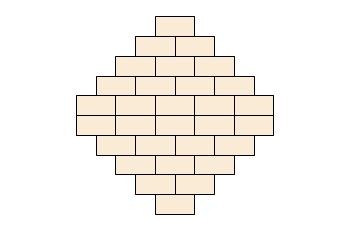

# 2


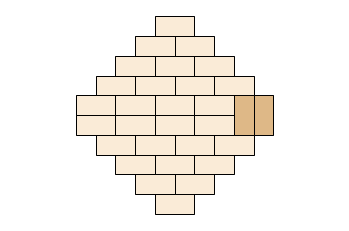

# 3


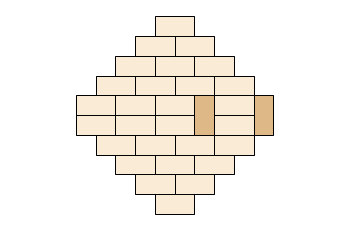

# 4


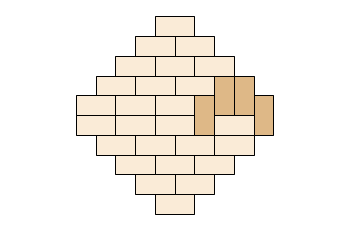

# 5


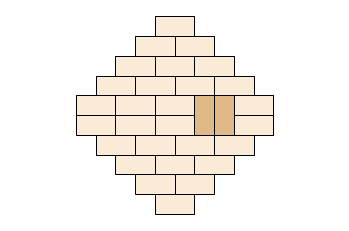

# 6


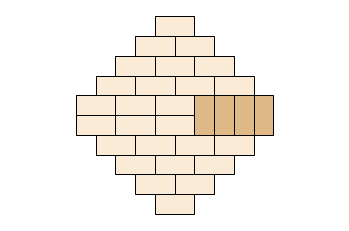

# 7


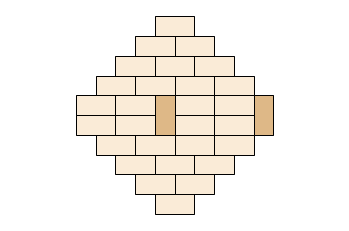

# 8


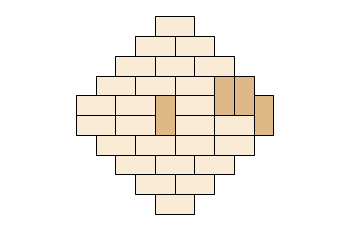

# 9


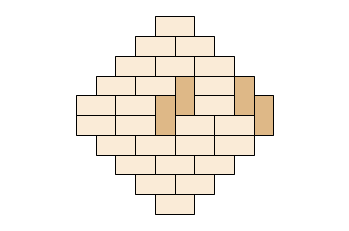

# 10


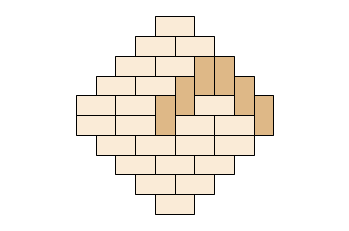

# 11


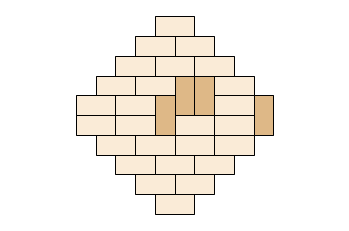

# 12


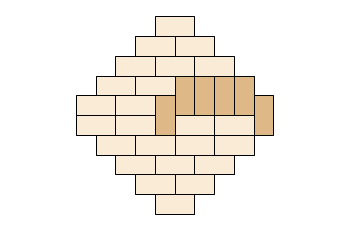

# 13


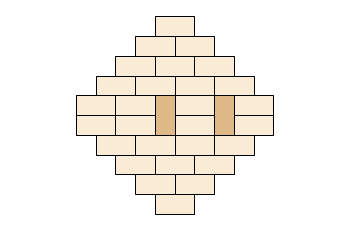

# 14


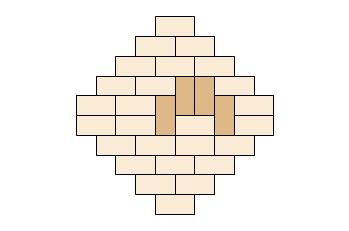

# 15


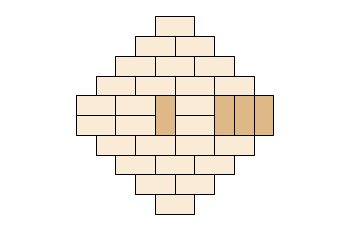

# 16


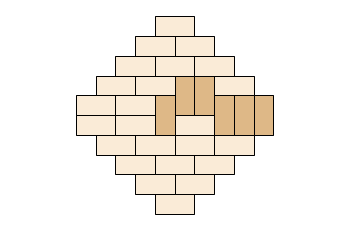

# 17


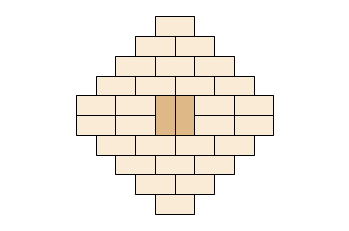

# 18


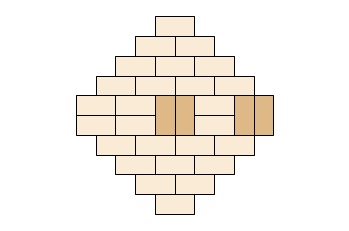

# 19


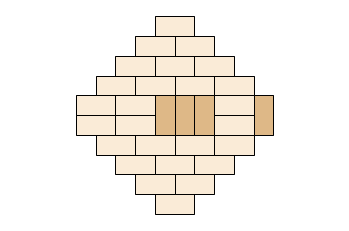

# 20


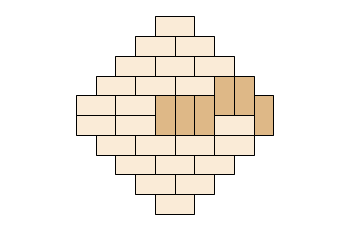

# 21


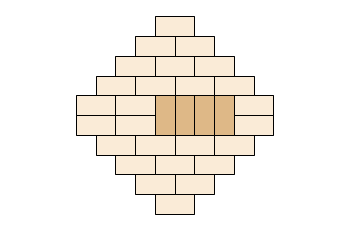

# 22


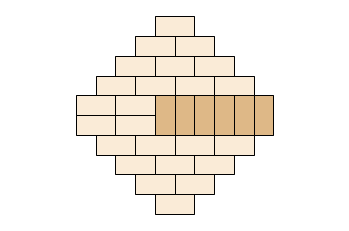

# 23


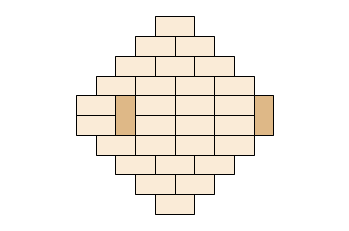

# 24


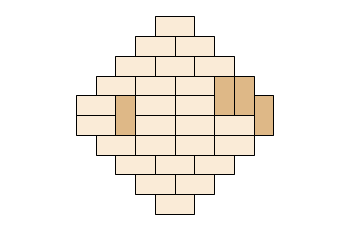

# 25


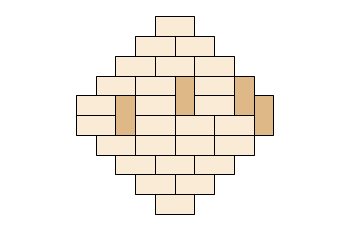

# 26


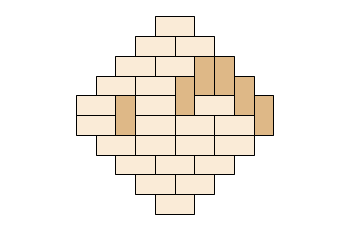

# 27


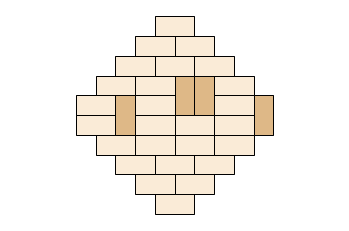

# 28


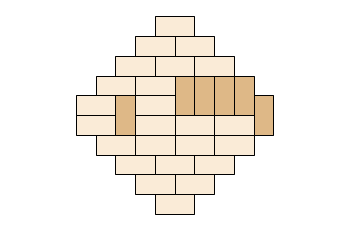

# 29


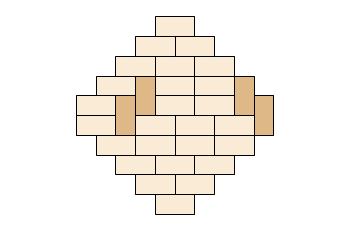

# 30


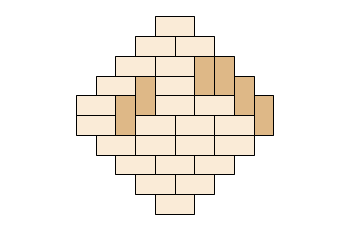

# 31


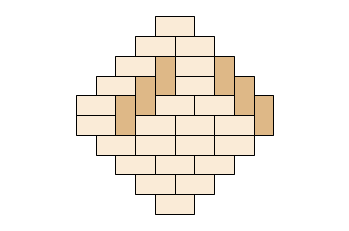

# 32


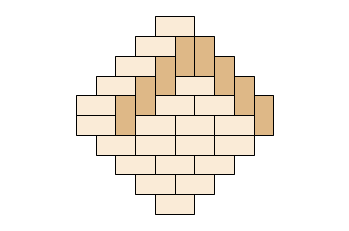

# 33


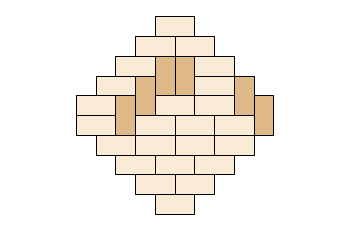

# 34


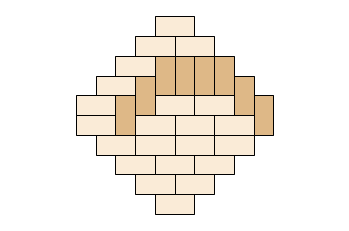

# 35


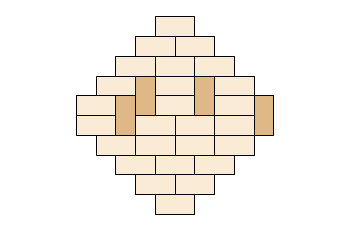

# 36


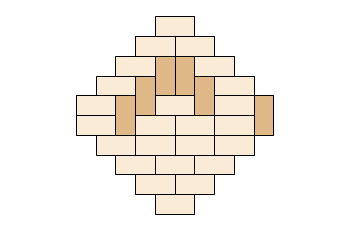

# 37


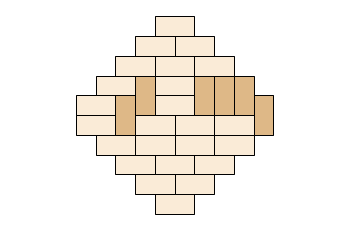

# 38


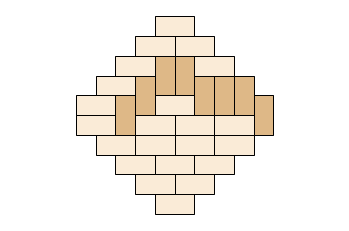

# 39


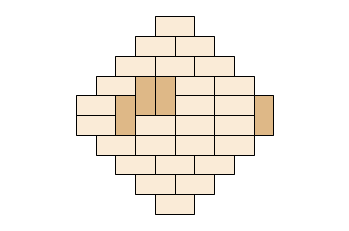

# 40


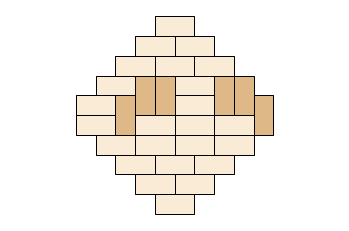

# 41


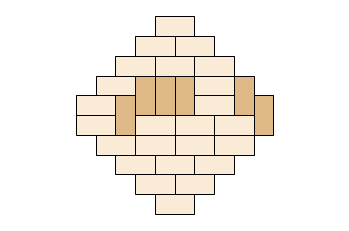

# 42


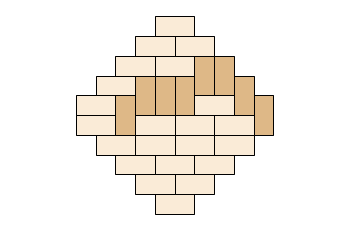

# 43


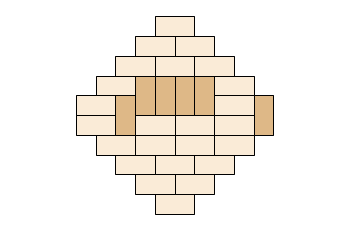

# 44


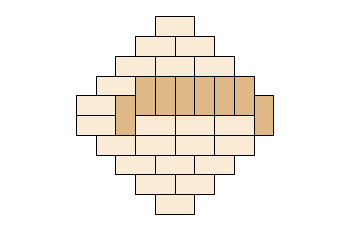

# 45


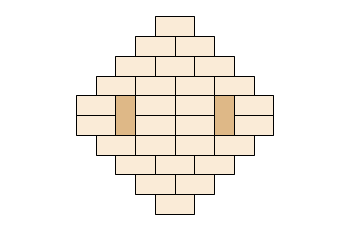

# 46


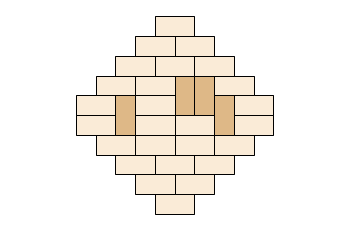

# 47


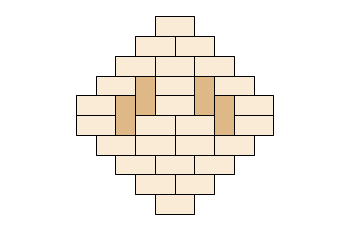

# 48


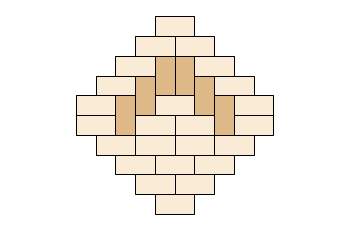

# 49


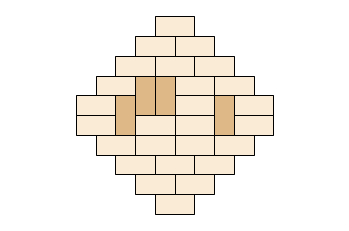

# 50


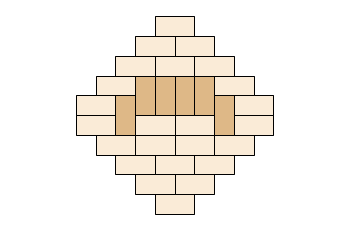

# 51


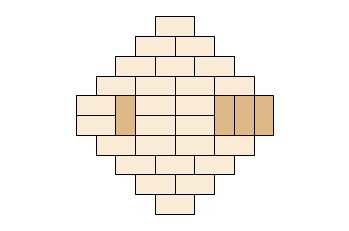

# 52


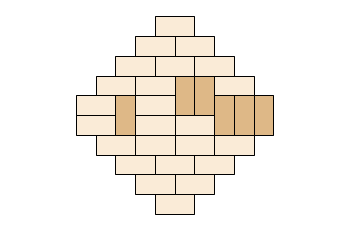

# 53


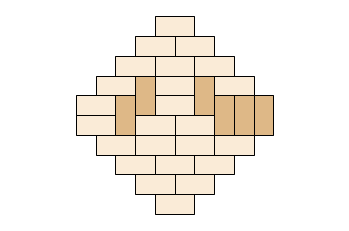

# 54


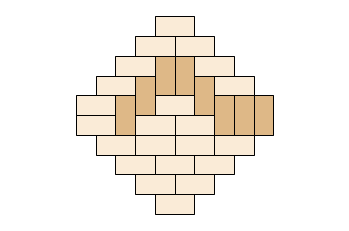

# 55


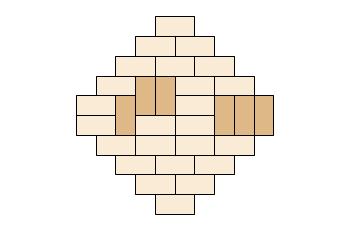

# 56


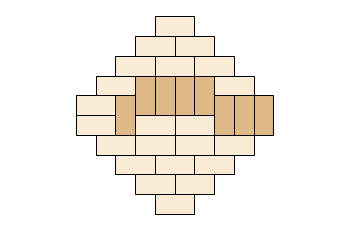

# 57


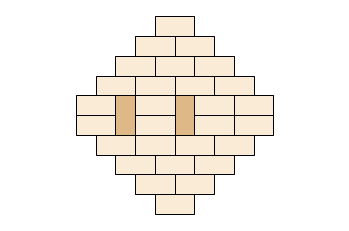

# 58


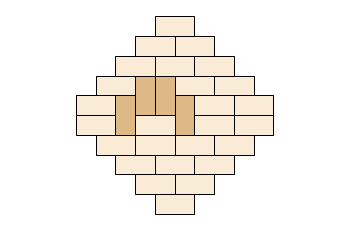

# 59


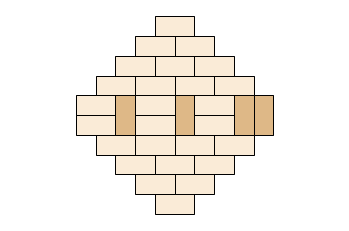

# 60


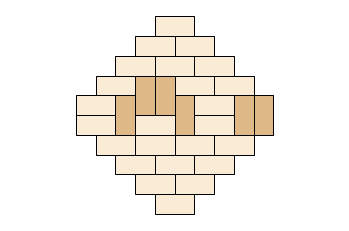

# 61


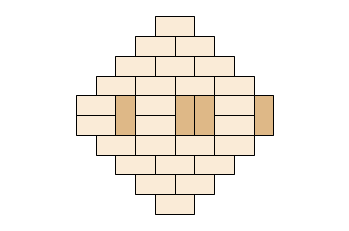

# 62


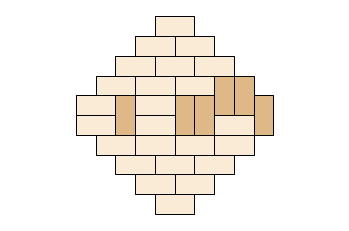

# 63


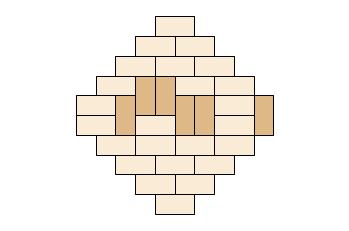

In [ ]:
# which frames to export
# NB you can set the frame_index so that the export doesn't have to start with j=0,
# or use a step value, e.g. range(100,640,10)
frame_index = list(range(0,64, 1))

for j,res in enumerate(getTilings(B), start=1):
  
  if j>max(frame_index):
    break
  elif j not in frame_index:
    continue
  
  print(f'# {j}')
  fig, ax = plt.subplots()

  # matplotlib, colortable: https://stackoverflow.com/questions/22408237/named-colors-in-matplotlib/37232760
  drawTiling(res, ax, vcolor='antiquewhite', hcolor='burlywood')

  # export and show the result
  plt.axis('off')
  plt.savefig("images/frame_{:04d}.png".format(j), dpi=None, transparent=True, bbox_inches='tight')
  plt.show()



## Convert image sequence into a gif animation at *Files/tiling.gif*

In [ ]:
!convert -delay 25 -loop 0 images/*.png -rotate -90 -trim +repage tiling.gif